# MCMC Fussing

In [1]:
import os
from importlib import resources

import numpy as np

import matplotlib.pyplot as plt

import emcee
import corner

import torch

from oceancolor.remote.nn import SimpleNet
from oceancolor.remote import io as remote_io

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [3]:
ab, Rs, _ = remote_io.load_loisel_2023_pca()

# Load NN

In [20]:
#model_file = os.path.join(resources.files('oceancolor'), 'remote', 'model_100.pth')
model_file = os.path.join(resources.files('oceancolor'), 'remote', 'model_20000.pth')
model = torch.load(model_file)

In [21]:
model

SimpleNet(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=81, bias=True)
  (fc2b): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=81, bias=True)
)

In [22]:
model.ab_parm

(array([ 2.08096461e+00,  3.35454187e+00, -1.11056838e+00, -8.14672149e-10,
        -1.18354213e-09,  1.02440709e-09]),
 array([2.78349807e-01, 2.60105492e-01, 7.43206412e-02, 9.76531044e-03,
        1.09479179e-03, 1.90594060e-04]))

# Probability

In [23]:
def log_prob(ab, Rs, model, device):
    pred = model.prediction(ab, device)
    #
    sig = 0.05 * Rs
    #
    return -1*0.5 * np.sum( (pred-Rs)**2 / sig**2)

# Random Walkers

In [24]:
ndim = model.ninput
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

# Target

In [25]:
idx = 200
means = Rs[idx]

In [26]:
ab[idx]

array([ 2.09002280e+00,  3.30304480e+00, -1.17997932e+00, -4.13763197e-03,
        3.63641593e-04, -1.42039862e-05])

In [27]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, model, device])

# Burn in

In [28]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [29]:
p0[0]

array([0.79057845, 0.82956035, 0.54682186, 0.69774538, 0.68966357,
       0.47327481])

# Run

In [38]:
sampler.run_mcmc(state, 20000);

In [42]:
samples = sampler.get_chain(flat=True)
samples.shape

(960000, 6)

# Plot

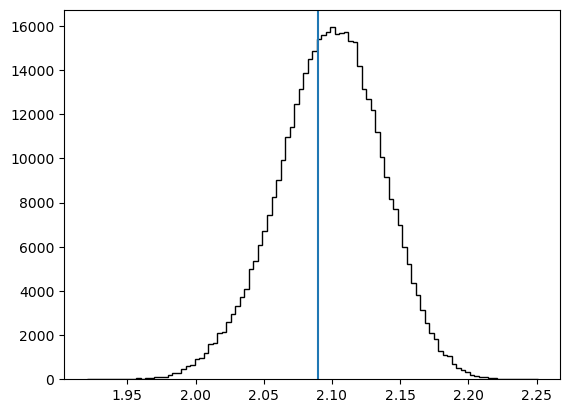

In [46]:
cidx = 0
plt.clf()
plt.hist(samples[500000:,cidx], 100, color='k', histtype='step')
ax = plt.gca()
ax.axvline(ab[idx][cidx])
#
plt.show()

# Corner plot

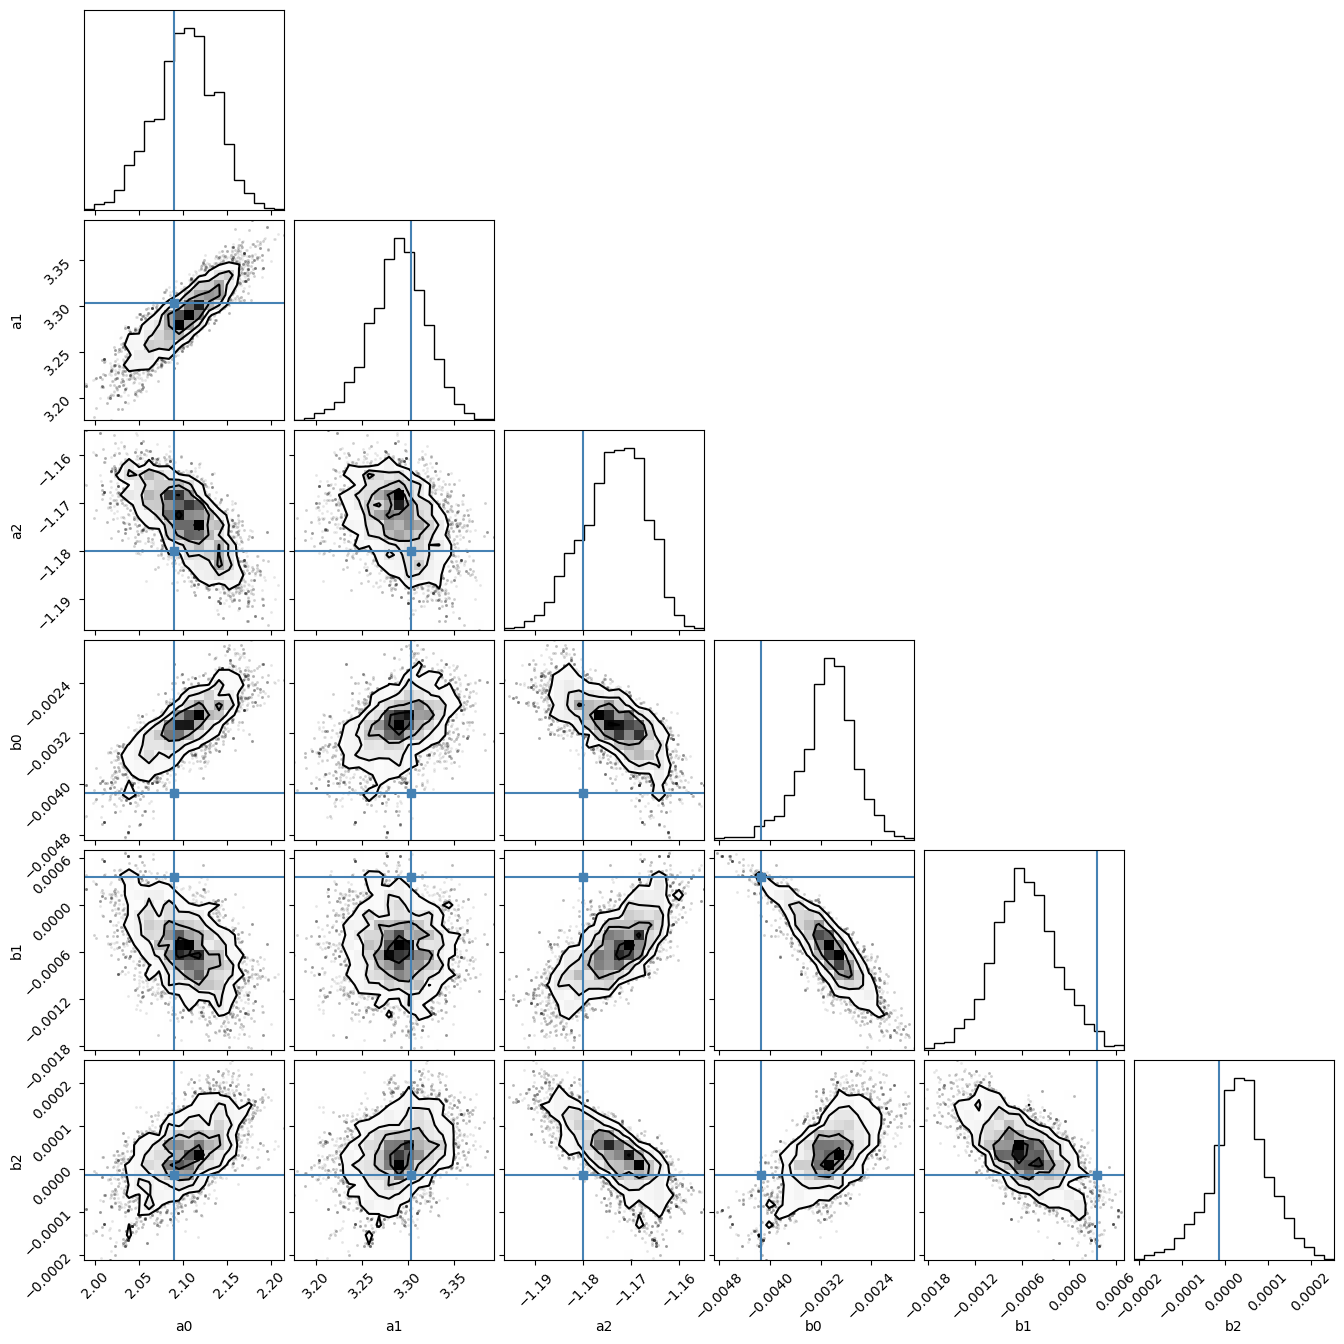

In [49]:
#fig = corner.corner(samples[500000:], labels=['a0', 'a1', 'a2', 'b0', 'b1', 'b2'],
fig = corner.corner(samples[-10000:], labels=['a0', 'a1', 'a2', 'b0', 'b1', 'b2'],
                    truths=ab[idx])

---- 

# Testing

In [77]:
samples[:,-1].shape

(320000,)

In [82]:
pred = model.prediction(samples[-1,:], device)
pred

array([1.7016067e+15, 1.6087121e+15, 1.3982078e+15, 1.3117116e+15,
       1.4493578e+15, 1.3237881e+15, 1.4930398e+15, 1.8020045e+15,
       1.7563148e+15, 1.6888121e+15, 1.5629461e+15, 1.4968958e+15,
       1.3026163e+15, 1.3914906e+15, 1.0966370e+15, 1.1672815e+15,
       9.4990738e+14, 7.9244059e+14, 7.5335941e+14, 6.8904697e+14,
       4.9199176e+14, 5.7623281e+14, 5.4224647e+14, 5.5033221e+14,
       4.6498551e+14, 3.7779898e+14, 2.4442771e+14, 3.0691068e+14,
       3.0127122e+14, 2.4637593e+14, 1.9516076e+14, 1.6526398e+14,
       1.0086292e+14, 1.0279936e+14, 8.0999040e+13, 9.3498259e+13,
       4.4333500e+13, 6.8159151e+13, 4.6311471e+13, 6.0774014e+13,
       5.6880697e+13, 4.0276853e+13, 4.7593900e+13, 5.1303233e+13,
       5.0917261e+13, 5.1241682e+13, 2.4165860e+13, 3.3784949e+13,
       2.1931634e+13, 2.4453203e+13, 2.0774451e+13, 2.1753290e+13,
       1.8264281e+13, 1.7975803e+13, 1.5348304e+13, 2.0495464e+13,
       1.0651163e+13, 1.5518778e+13, 1.9602227e+13, 1.9711698e

In [80]:
pred = model.prediction(ab[idx], device)
pred

array([2.7662888e-03, 2.9148874e-03, 3.1095059e-03, 3.2807994e-03,
       3.4793075e-03, 3.6345324e-03, 3.8075321e-03, 4.2071999e-03,
       4.2475709e-03, 4.3116277e-03, 4.3672975e-03, 4.3981508e-03,
       4.6101152e-03, 4.7363145e-03, 4.9556545e-03, 5.0201593e-03,
       4.9696993e-03, 4.9452782e-03, 4.8327963e-03, 4.7496040e-03,
       4.5772241e-03, 4.5990199e-03, 4.7164117e-03, 4.7902218e-03,
       4.7043664e-03, 4.7598151e-03, 4.5940895e-03, 4.5192931e-03,
       4.3631233e-03, 4.1075298e-03, 3.7774225e-03, 3.3359034e-03,
       2.8534126e-03, 2.4767679e-03, 2.3943624e-03, 2.3368045e-03,
       2.2400504e-03, 2.1517875e-03, 2.0384933e-03, 1.8627306e-03,
       1.6717898e-03, 1.5682479e-03, 1.5053246e-03, 1.4153229e-03,
       1.2821828e-03, 1.1473484e-03, 9.7208802e-04, 7.8203535e-04,
       6.3114212e-04, 5.0090143e-04, 3.7118566e-04, 3.0890590e-04,
       2.9425047e-04, 2.8834958e-04, 2.7163781e-04, 2.5169531e-04,
       2.4110237e-04, 2.2814394e-04, 2.1956247e-04, 2.0556622e

In [81]:
log_prob(samples[-1,:], means, model, device)

inf

In [63]:
log_prob(ab[idx], means, model, device)

NameError: name 'ab_norm' is not defined

In [51]:
(pred-means)/pred

array([-0.08126818, -0.08474173, -0.06531398, -0.04047811, -0.02704344,
       -0.01586655,  0.00794008,  0.04939151,  0.04420666,  0.01600968,
        0.04755744,  0.03498079,  0.05924255,  0.06131652,  0.08314832,
        0.08168256,  0.05539559,  0.05934517,  0.05717112,  0.05994266,
        0.04911799,  0.04725353,  0.0462241 ,  0.0373723 ,  0.01285329,
        0.02966818,  0.02376742,  0.02683896,  0.03429275,  0.04567948,
        0.04074802,  0.05168118,  0.05386977,  0.05231331,  0.05423676,
        0.05571903,  0.06194071,  0.06896017,  0.06999939,  0.06513589,
        0.06106619,  0.06577272,  0.07687686,  0.06968224,  0.06464188,
        0.07839677,  0.07734691,  0.07456868,  0.06273087,  0.06436681,
        0.06483458,  0.05524629,  0.05665401,  0.07105806,  0.07310398,
        0.04853215,  0.05770318,  0.05660434,  0.0686022 ,  0.06185948,
        0.06580777,  0.06256645,  0.06685673,  0.09807864,  0.10190737,
        0.10018446,  0.10776525,  0.11778813,  0.14843091,  0.10

In [19]:
np.sqrt(0.006)

0.07745966692414834